In [2]:
pip install rasterio

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
import tensorflow as tf
from PIL import Image

*   # **Data Exploration/Cleaning**

In [6]:
# Set paths to image and mask directories
image_dir = '/kaggle/input/satellite/data/images'
mask_dir = '/kaggle/input/satellite/data/labels'

# Load the first image and corresponding mask
image_path = os.path.join(image_dir, os.listdir(image_dir)[0])
mask_path = os.path.join(mask_dir, os.listdir(mask_dir)[0])

# Load the multispectral image (.tif)
with rasterio.open(image_path) as src:
    image = src.read()  # shape: (12, 128, 128)
    image = np.moveaxis(image, 0, -1)  # convert to shape: (128, 128, 12)

# Load the binary mask (.png)
mask = np.array(Image.open(mask_path))

# Display shape and unique values
print("Image shape:", image.shape)
print("Image dtype:", image.dtype)
print("Mask shape:", mask.shape)
print("Unique values in mask:", np.unique(mask))

Image shape: (128, 128, 12)
Image dtype: int16
Mask shape: (128, 128)
Unique values in mask: [0 1]


In [7]:
##--Normalize image--##

def normalize_image(img):
    img = img.astype(np.float32)
    img_min = np.min(img)
    img_max = np.max(img)
    normalized = (img - img_min) / (img_max - img_min + 1e-6)
    return normalized

normalized_image = normalize_image(image)

# Confirm results
print("Before normalization:", image.min(), image.max())
print("After normalization:", normalized_image.min(), normalized_image.max())
print("New dtype:", normalized_image.dtype)


Before normalization: -375 6073
After normalization: 0.0 1.0
New dtype: float32


In [8]:
# Convert mask to float32
mask = mask.astype(np.float32)

# Optional: expand dims if needed (e.g., (128, 128) → (128, 128, 1))
mask = np.expand_dims(mask, axis=-1)

print("Mask shape after expand:", mask.shape)
print("Mask dtype:", mask.dtype)
print("Mask unique values:", np.unique(mask))



Mask shape after expand: (128, 128, 1)
Mask dtype: float32
Mask unique values: [0. 1.]


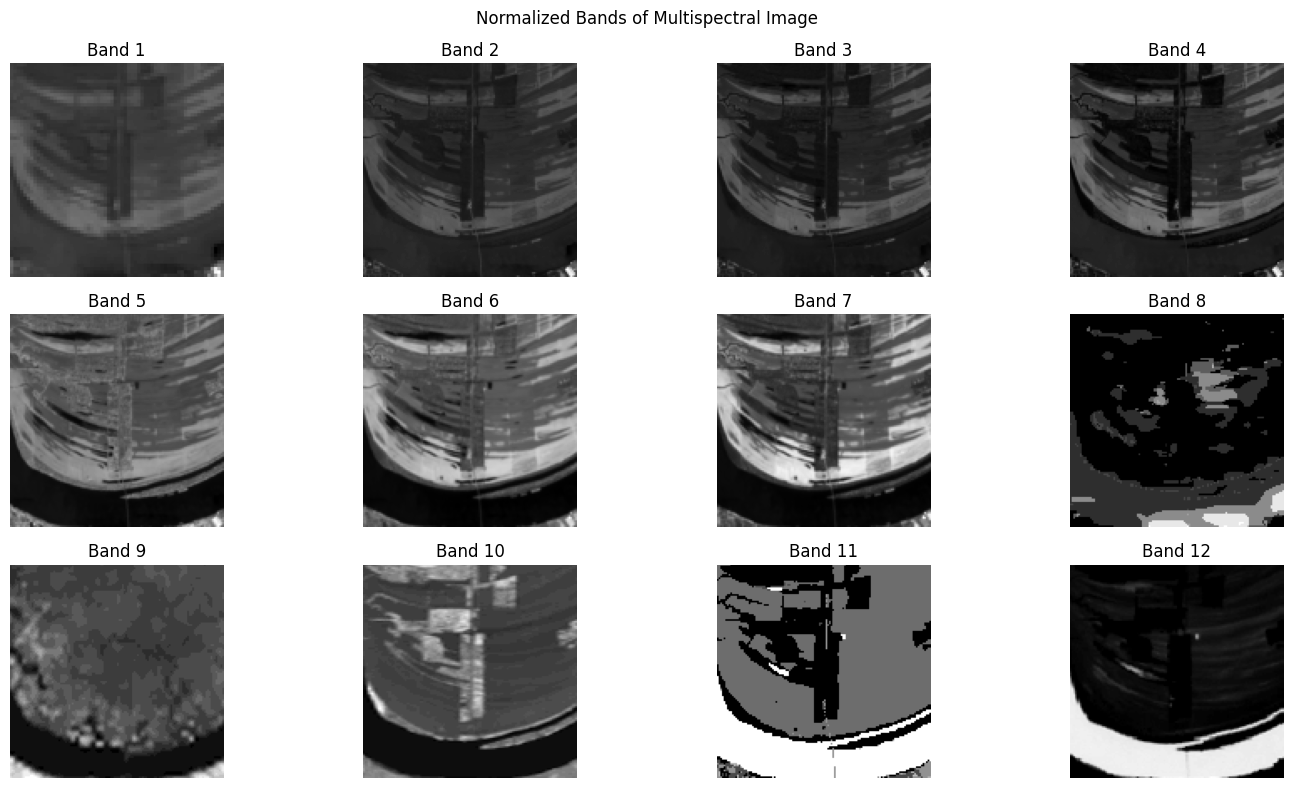

In [9]:
#Sample of normalized band
def normalize_band(band):
    return (band - band.min()) / (band.max() - band.min() + 1e-6)

# Plot the 12 bands in a grid
plt.figure(figsize=(15, 8))
for i in range(12):
    band = image[:, :, i
    ]
    norm_band = normalize_band(band)
    plt.subplot(3, 4, i+1)
    plt.imshow(norm_band, cmap='gray')
    plt.title(f'Band {i+1}')
    plt.axis('off')

plt.suptitle('Normalized Bands of Multispectral Image')
plt.tight_layout()
plt.show()

* # **Preprocessing**

In [10]:
##--Load data and normalize it--##

# Load and sort filenames without extensions
image_names = set([f.replace('.tif', '') for f in os.listdir(image_dir) if f.endswith('.tif')])
mask_names = set([f.replace('.png', '') for f in os.listdir(mask_dir) if f.endswith('.png')])

# Intersect to get common files
common_names = sorted(list(image_names & mask_names))

# Now create full paths again
image_files = [os.path.join(image_dir, name + '.tif') for name in common_names]
mask_files = [os.path.join(mask_dir, name + '.png') for name in common_names]

print("Matched image-mask pairs:", len(image_files))

Matched image-mask pairs: 306


In [11]:
def load_and_preprocess(image_path, mask_path):
    # Decode bytes to string (TensorFlow inputs are tf.string)
    image_path = image_path.numpy().decode('utf-8')
    mask_path = mask_path.numpy().decode('utf-8')

    # Load image (.tif) using rasterio
    with rasterio.open(image_path) as src:
        image = src.read()  # shape: (12, 128, 128)
        image = np.moveaxis(image, 0, -1)  # (128, 128, 12)
        image = image.astype(np.float32)
        image = (image - image.min()) / (image.max() - image.min() + 1e-6)

    # Load mask (.png) using PIL
    mask = np.array(Image.open(mask_path)).astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)  # (128, 128, 1)

    return image, mask


In [12]:
def tf_wrapper(image_path, mask_path):
    image, mask = tf.py_function(func=load_and_preprocess,
                                  inp=[image_path, mask_path],
                                  Tout=[tf.float32, tf.float32])
    image.set_shape([128, 128, 12])
    mask.set_shape([128, 128, 1])
    return image, mask


In [14]:
# Create TensorFlow dataset
path_ds = tf.data.Dataset.from_tensor_slices((image_files, mask_files))

# Map preprocessing function
dataset = path_ds.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle, batch, prefetch
train_dataset = dataset.shuffle(100).batch(8).prefetch(tf.data.AUTOTUNE)


In [15]:
for images, masks in train_dataset.take(1):
    print("Images batch shape:", images.shape)
    print("Masks batch shape:", masks.shape)
    print("Image dtype:", images.dtype)
    print("Mask dtype:", masks.dtype)


Images batch shape: (8, 128, 128, 12)
Masks batch shape: (8, 128, 128, 1)
Image dtype: <dtype: 'float32'>
Mask dtype: <dtype: 'float32'>


In [16]:
import matplotlib.pyplot as plt

# Define which bands to visualize (e.g., bands 4, 3, 2)
BAND_RED = 3
BAND_GREEN = 2
BAND_BLUE = 1

def show_sample(image, mask, idx=0):
    img = image[idx].numpy()
    msk = mask[idx].numpy().squeeze()

    # Pick selected bands and stack into RGB
    rgb = np.stack([
        img[:, :, BAND_RED],
        img[:, :, BAND_GREEN],
        img[:, :, BAND_BLUE]
    ], axis=-1)

    # Normalize for display
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())

    # Plot
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(rgb)
    plt.title("RGB Composite (Bands 4-3-2)")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(msk, cmap='gray')
    plt.title("Water Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


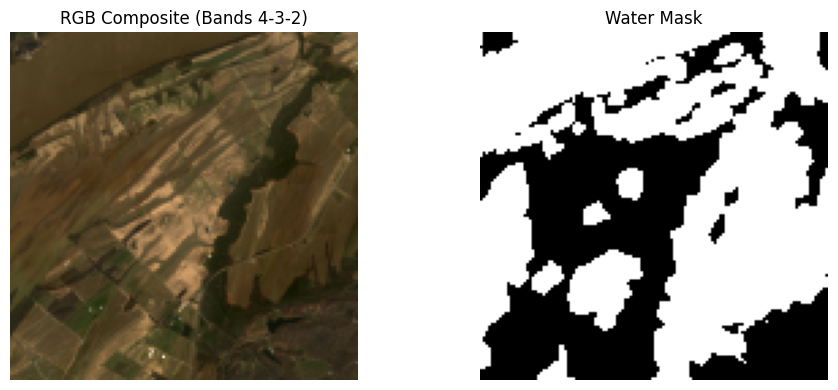

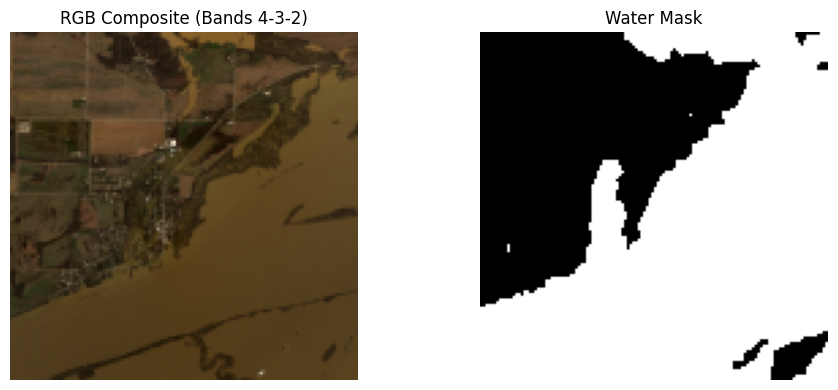

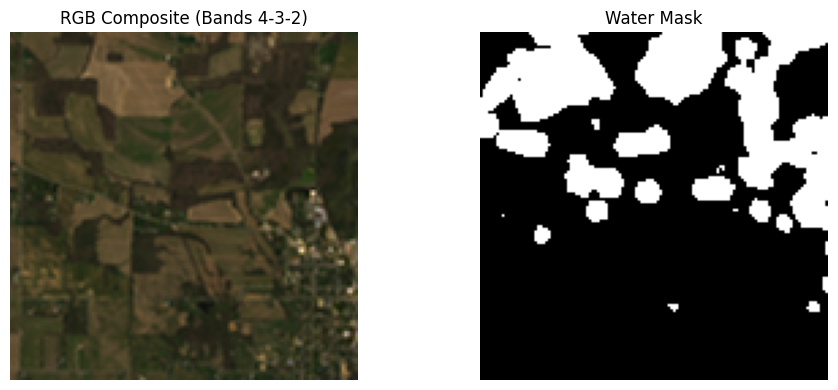

In [17]:
for i in range(3):
    show_sample(images, masks, idx=i)

* # **data split** 

In [18]:
from sklearn.model_selection import train_test_split

# Step 1: Split paths
train_images, val_images, train_masks, val_masks = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42
)

# Step 2: Build train & val datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_masks))

# Step 3: Map preprocessing
train_dataset = train_ds.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_ds.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)

# Step 4: Shuffle, Batch, Prefetch
train_dataset = train_dataset.shuffle(100).batch(8).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(8).prefetch(tf.data.AUTOTUNE)


* # **Modeling** 

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [20]:
def simple_cnn_segmentation(input_shape=(128, 128, 12)):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model


In [21]:
model = simple_cnn_segmentation(input_shape=(128, 128, 12))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 188,129 (734.88 KB)

 Trainable params: 188,129 (734.88 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_cnn_model.h5',   # عدلنا الاسم من unet لـ cnn
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1
)

callbacks = [early_stop, checkpoint, reduce_lr]


In [23]:
model.fit(
    train_dataset,               # أو (X_train, y_train)
    validation_data=val_dataset,  # أو (X_val, y_val)
    epochs=100,
    batch_size=8,
    callbacks=callbacks
)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.7186 - loss: 0.5455
Epoch 1: val_loss improved from inf to 0.36199, saving model to best_cnn_model.h5
31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 680ms/step - accuracy: 0.7210 - loss: 0.5432 - val_accuracy: 0.8585 - val_loss: 0.3620 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.8635 - loss: 0.3643
Epoch 2: val_loss improved from 0.36199 to 0.30718, saving model to best_cnn_model.h5
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 652ms/step - accuracy: 0.8640 - loss: 0.3633 - val_accuracy: 0.8929 - val_loss: 0.3072 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.8711 - loss: 0.3500
Epoch 3: val_loss improved from 0.30718 to 0.29270, saving model to best_cnn_model.h5
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 634ms/step - accuracy: 0.8716 - loss: 0.3490 - val_accuracy: 0.8750 - val_loss: 0.2927 - learning_rate: 0.0010
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accu

In [25]:
model.save("CNN_water_segmentation.h5")


In [26]:
loss, accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.9332 - loss: 0.1637
Validation Loss: 0.1573
Validation Accuracy: 0.9363


In [27]:
# Get one batch of validation data
for images, true_masks in val_dataset.take(1):
    pred_masks = model.predict(images)
    break

# Apply threshold to convert probabilities to binary (0 or 1)
pred_binary = (pred_masks > 0.5).astype(np.uint8)
true_binary = true_masks.numpy().astype(np.uint8)

from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

# Flatten arrays (needed for sklearn metrics)
y_true = true_binary.flatten()
y_pred = pred_binary.flatten()

# Compute metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
iou = jaccard_score(y_true, y_pred)

# Display results
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"IoU:       {iou:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
Precision: 0.8967
Recall:    0.7408
F1-score:  0.8113
IoU:       0.6825


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step


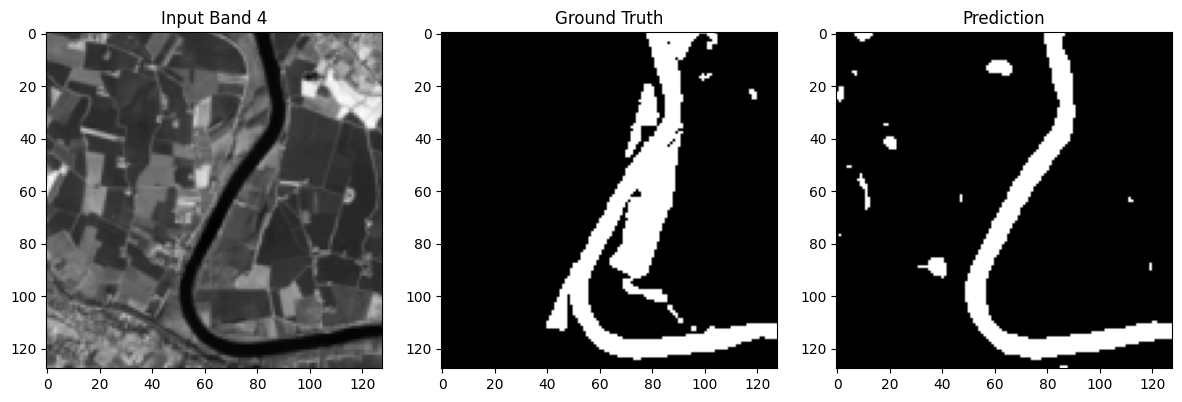

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Get a single (image, mask) sample from val_dataset
sample_image, sample_mask = next(iter(val_dataset))

# Take the first element from the batch
sample_image = sample_image[0].numpy()
sample_mask = sample_mask[0].numpy()

# Predict
pred = model.predict(sample_image[np.newaxis, ...])[0]
pred_binary = (pred > 0.5).astype(np.uint8)

# Visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(sample_image[:, :, 4], cmap='gray')  # عرض قناة واحدة فقط
plt.title("Input Band 4")

plt.subplot(1, 3, 2)
plt.imshow(sample_mask[:, :, 0], cmap='gray')
plt.title("Ground Truth")

plt.subplot(1, 3, 3)
plt.imshow(pred_binary[:, :, 0], cmap='gray')
plt.title("Prediction")

plt.tight_layout()
plt.show()
